In [8]:
from google.colab import drive
drive.mount('/content/drive')  # 挂载到默认路径
# Mount to Google Drive & Switch to the dataset directory
import os

os.chdir("/content/drive/MyDrive/ml_final_competition")
os.listdir()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['label2type.txt', 'model.py', 'train.npz', 'Copy of demo.ipynb']

In [9]:
import torch
import random
import numpy as np

# Set a fixed random seed for reproducibility  尽可能地保证训练/推理过程在每次运行时都能得到相同的结果，在调试模型、对比实验时非常重要。
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [10]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):  #load from npz data file
    def __init__(self, npz_path):
        npz_data = np.load(npz_path)
        self.images = npz_data["images"] # (N, 3, 128, 128) in np.uint8
        self.labels = npz_data["labels"] # (N,) in np.int64
        assert self.images.shape[0] == self.labels.shape[0]
        print(f"{npz_path}: images shape {self.images.shape}, "
              f"labels shape {self.labels.shape}")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = torch.tensor(self.images[idx]) / 255 # convert to [0, 1] range
        label = torch.tensor(self.labels[idx])
        return image, label

train_dataset = CustomDataset("train.npz")
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

train.npz: images shape (18900, 3, 128, 128), labels shape (18900,)


In [11]:
# sample data batch
images, labels = next(iter(train_loader))
print(f"images shape: {images.shape}")
print(f"labels shape: {labels.shape}")

images shape: torch.Size([128, 3, 128, 128])
labels shape: torch.Size([128])


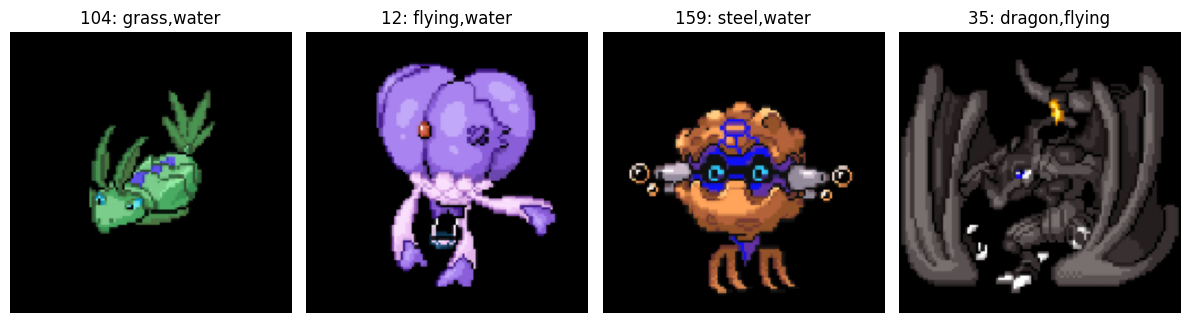

In [12]:
import matplotlib.pyplot as plt

# load label text
with open('label2type.txt', 'r') as f:
    label2type = eval(f.read())

# plot samples
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i, ax in enumerate(axes):
    label = labels[i].item()
    # (C, H, W) to (H, W, C) for plotting
    ax.imshow(images[i].numpy().transpose(1, 2, 0))
    ax.axis('off')
    ax.set_title(f"{label}: {label2type[label]}")
plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#model class

class ConvVAE(nn.Module):
    def __init__(self, input_channels=3, latent_channels=4):
        super().__init__()

        # --- Encoder ---
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=2, padding=1),  # 64 x 64 x 64
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),             # 128 x 32 x 32
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),            # 256 x 32 x 32
            nn.ReLU()
        )

        # --- Quantization conv ---
        self.quant_conv = nn.Conv2d(256, latent_channels * 2, kernel_size=1)    # 4+4 channels

        # --- Decoder ---
        self.post_quant_conv = nn.Conv2d(latent_channels, 256, kernel_size=1)

        self.decoder = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),            # 128 x 32 x 32
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),    # 64 x 64 x 64
            nn.ReLU(),
            nn.ConvTranspose2d(64, input_channels, kernel_size=4, stride=2, padding=1), # 3 x 128 x 128
            nn.Sigmoid() # Predict within value range [0, 1]
        )

    def preprocess(self, x):
        return 2 * x - 1 # Value range: [0, 1] => [-1, 1]

    def encode(self, x):
        x = self.preprocess(x)
        h = self.encoder(x)
        h = self.quant_conv(h)
        mean, logvar = torch.chunk(h, 2, dim=1) # Split along channel (4+4)
        if self.training:
            logvar = logvar.clamp(-30.0, 20.0)
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            z = mean + eps * std
        else:
            z = mean
        return z, mean, logvar

    def decode(self, z):
        h = self.post_quant_conv(z)
        x_recon = self.decoder(h)
        return x_recon

    def forward(self, x):
        z, mean, logvar = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, z, mean, logvar


In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

# ----- Loss Function -----
def vae_loss(x, x_recon, mean, logvar, kl_weight=0.1):
    recon_loss = F.mse_loss(x, x_recon, reduction='mean')
    kl_loss = -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())
    final_loss = recon_loss + kl_weight * kl_loss
    return final_loss, recon_loss, kl_loss

# ----- Training -----
def train_vae(model, dataloader, optimizer, device, num_epochs=1):
    model.train()
    for epoch in range(num_epochs):
        loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
        # loop = dataloader
        for images, labels in loop:
            x, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            x_recon, z, mean, logvar = model(x)
            loss, recon_loss, kl_loss = vae_loss(x, x_recon, mean, logvar)
            loss.backward()
            optimizer.step()
            loop.set_postfix(loss=loss.item(), recon=recon_loss.item(), kl=kl_loss.item())

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
model = ConvVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train
train_vae(model, train_loader, optimizer, device, num_epochs=5)

Epoch 5/5: 100%|██████████| 148/148 [00:28<00:00,  5.23it/s, kl=0.0845, loss=0.0232, recon=0.0147]


Latent bottleneck dimension: 4096


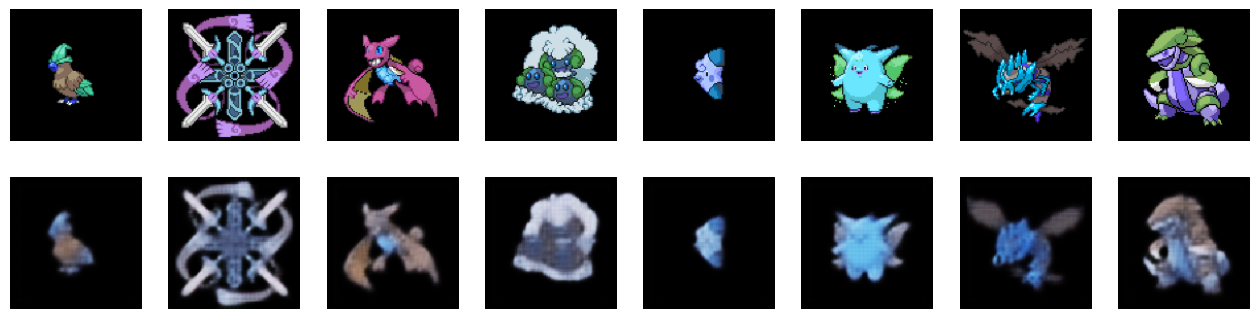

In [ ]:
# ----- Visualization -----
def plot_reconstructions(model, dataloader, device, num_images=8):
    model.eval()
    with torch.no_grad():
        x = next(iter(dataloader))[0].to(device)
        x_recon, z, _, _ = model(x)
        x = x.cpu().numpy()
        x_recon = x_recon.cpu().numpy()
        print(f"Latent bottleneck dimension: {z.flatten(start_dim=1).shape[1]}")

        plt.figure(figsize=(16, 4))
        for i in range(num_images):
            # Original
            plt.subplot(2, num_images, i+1)
            plt.imshow(x[i].transpose(1, 2, 0))  # (C, H, W) -> (H, W, C)
            plt.axis('off')

            # Reconstruction
            plt.subplot(2, num_images, i+1+num_images)
            plt.imshow(x_recon[i].transpose(1, 2, 0))
            plt.axis('off')

        plt.show()

plot_reconstructions(model, train_loader, device, num_images=8)

In [ ]:
# Submission

# 1) Save model weights
torch.save(model.state_dict(), "checkpoint.pt")

# 2) Prepare the 'Model' class for submission
with open("model.py", "r") as f:
    print(f.read())

# 3) Submit the model code & weights online

import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, input_channels=3, latent_channels=4):
        super().__init__()
        # Make sure the layers are consistent with your checkpoint weights
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.quant_conv = nn.Conv2d(256, latent_channels * 2, kernel_size=1)
        self.post_quant_conv = nn.Conv2d(latent_channels, 256, kernel_size=1)
        self.decoder = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose

In [ ]:
# Metric 1: Recon MSE on test set (on value range [0, 1])
# Metric 2: Classification accuracy (linear probing with test set latents, 170 classes)
# Final Score: recon_mse / probing_accuracy (the lower the better)